# Julia objectives

This notebook demonstrates the application of pyPESTO to objective functions defined in [Julia](https://julialang.org/).

- there is an issue in minimize with the SIR model
- LR model runs without Error but all waterfall fvals are the same (prob. bec. global minimum reached)

As demonstration example, we use an [SIR disease dynamcis model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). For simulation, we use [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/).

The code consists of multiple functions in the file `model_julia/SIR.jl`, wrapped in the namespace of a module `SIR`. We first speficy the reaction network via `Catalyst` (this is optional, one can also directly start with the differential equations), and then translate them to an ordinary differential equation (ODE) model in `OrdinaryDiffEq`. Then, we create synthetic observed `data` with normal noise. After that, we define a quadratic cost function `fun` (the negative log-likelihood under an additive normal noise model). We use forward automatic differentiation via `ForwardDiff` to derive also the gradient `grad` (there exist various derivative calculation methods, including forward and adjoint, and continuous and discrete sensitivities, see [SciMLSensitivity.jl](https://sensitivity.sciml.ai/dev/)):

In [1]:
from pypesto.objective.julia import display_source_ipython

display_source_ipython("model_julia/SIR.jl")

We make the cost function and gradient known to `JuliaObjective`. Importing module and dependencies, and initializing some operations, can take some time due to pre-processing.

In [2]:
import pypesto
from pypesto.objective.julia import JuliaObjective

In [3]:
%%time

obj = JuliaObjective(
    module="SIR",
    source_file="model_julia/SIR.jl",
    fun="fun",
    grad="grad"
)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
CPU times: user 20.4 s, sys: 749 ms, total: 21.1 s
Wall time: 20.9 s


That's it -- now we have an objective function that we can simply use in pyPESTO like any other. Internally, it delegates all calls to Julia and translates results.

## Comments

Before continuing with the workflow, some comments:

When calling a function for the first time, Julia performs some internal pre-processing. Subsequent function calls are much more efficient.

In [4]:
import numpy as np

x = np.array([-4.0, -2.0])

%time print(obj.get_fval(x))
%time print(obj.get_fval(x))
%time print(obj.get_grad(x))
%time print(obj.get_grad(x))

23.122284878899872
CPU times: user 1.14 s, sys: 16.4 ms, total: 1.15 s
Wall time: 1.14 s
23.122284878899872
CPU times: user 220 µs, sys: 21 µs, total: 241 µs
Wall time: 244 µs
[-38.82769857  19.95270485]
CPU times: user 2.53 s, sys: 24.3 ms, total: 2.55 s
Wall time: 2.54 s
[-38.82769857  19.95270485]
CPU times: user 317 µs, sys: 28 µs, total: 345 µs
Wall time: 324 µs


The outputs are already numpy arrays (in custom Julia objectives, it needs to be made sure that return objects can be parsed to floats and numpy arrays in Python).

In [5]:
type(obj.get_grad(x))

numpy.ndarray

Here, we use backward automatic differentiation to calculate the gradient. We can verify its correctness via finite difference checks:

In [6]:
from pypesto import FD

fd = FD(obj, grad=True)

fd.get_grad(x)

array([-38.75164233,  19.96612076])

Further, we can use the `JuliaObjective.get()` function to directly access any variable in the Julia module. Make sure to catch the `Julia` data types appropriately.

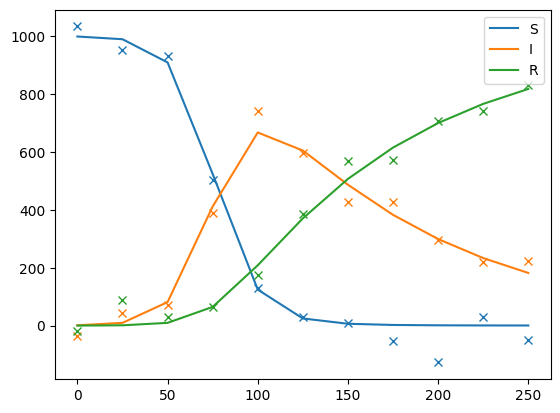

In [7]:
sol_true_t = np.asarray(obj.get("sol_true").t)
sol_true_u = np.asarray([np.asarray(i) for i in obj.get("sol_true").u])
data = np.asarray(obj.get("data")).T

import matplotlib.pyplot as plt

for i, label in zip(range(3), ["S", "I", "R"]):
    plt.plot(sol_true_t, sol_true_u[:, i], color=f"C{i}", label=label)
    plt.plot(sol_true_t, data[:, i], "x", color=f"C{i}")
plt.legend();

## Inference problem

Let us define an inference problem by specifying parameter bounds. Note that we use a log10-transformation of parameters in `fun`.

In [8]:
from pypesto import Problem

# parameter boundaries
lb, ub = [-5.0, -3.0], [-3.0, -1.0]

# estimation problem
problem = Problem(obj, lb=lb, ub=ub)

## Optimization

Let us perform an optimization:

In [9]:
%%time

# optimize
from pypesto import optimize

result = optimize.minimize(problem)

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 390.36it/s]


CPU times: user 267 ms, sys: 275 µs, total: 267 ms
Wall time: 266 ms


The objective function evaluations are quite fast!

We can also use parallelization, by passing a `pypesto.engine.MultiProcessEngine` to the `minimize` function.

In [10]:
%%time

from pypesto.engine import MultiProcessEngine

engine = MultiProcessEngine()
result = optimize.minimize(problem, engine=engine, n_starts=100)

Engine will use up to 8 processes (= CPU count).
100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1456.04it/s]


CPU times: user 46.9 ms, sys: 268 ms, total: 315 ms
Wall time: 418 ms


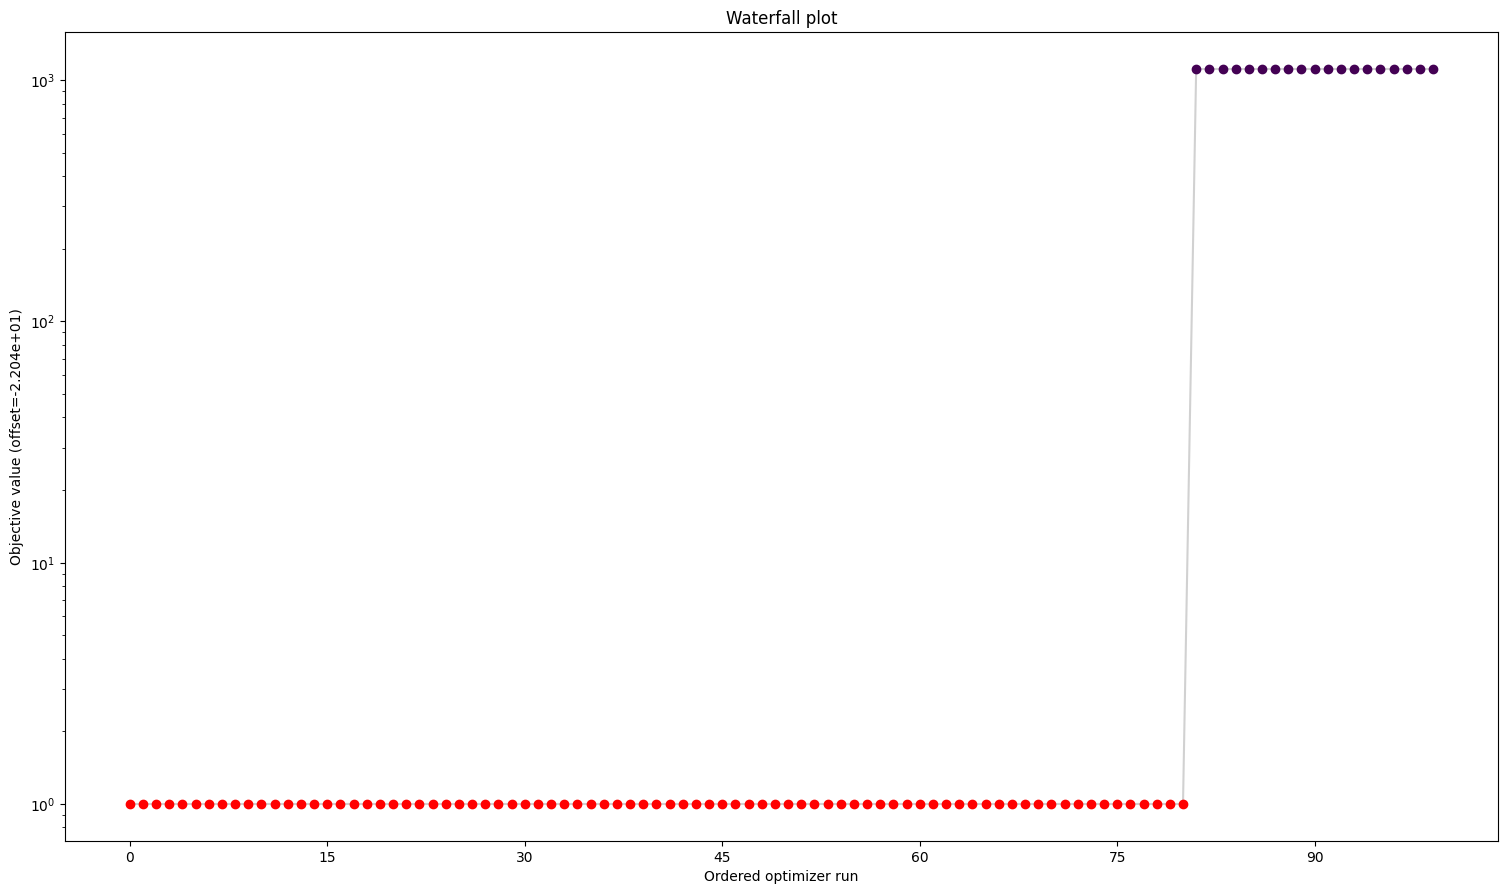

In [11]:
from pypesto import visualize

visualize.waterfall(result);

## Sampling

Last, let us perform sampling from the log-posterior with implicitly defined uniform prior via the parameter bounds:

In [12]:
%%time

from pypesto import sample

sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3
)

result = sample.sample(
    problem, n_samples=10000, sampler=sampler, result=result
)

Initializing betas with "near-exponential decay".
100%|███████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1954.11it/s]
Elapsed time: 5.128078679999998


CPU times: user 5.1 s, sys: 35.3 ms, total: 5.14 s
Wall time: 5.13 s


Geweke burn-in index: 0


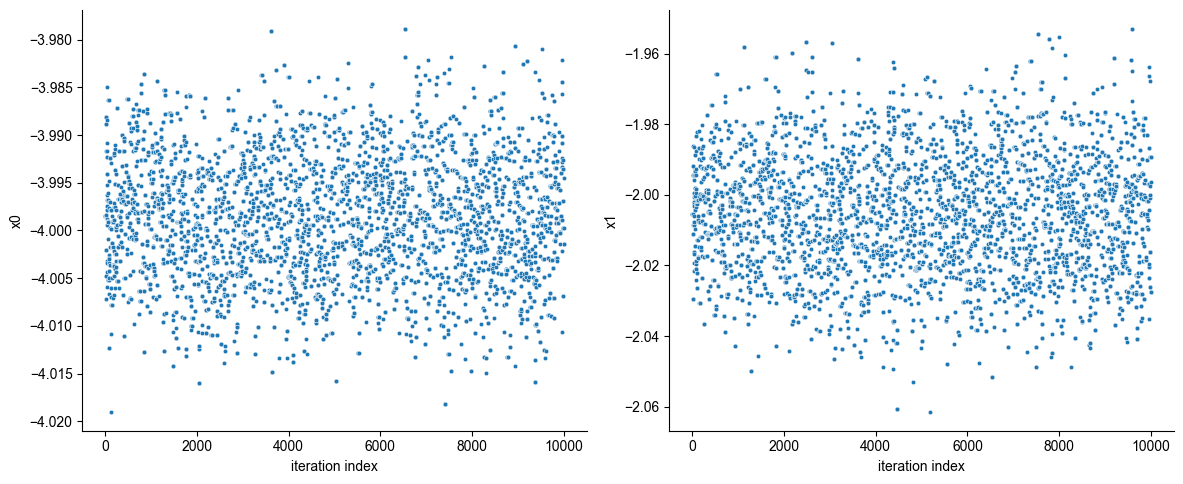

In [13]:
pypesto.sample.geweke_test(result)
visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5)
);

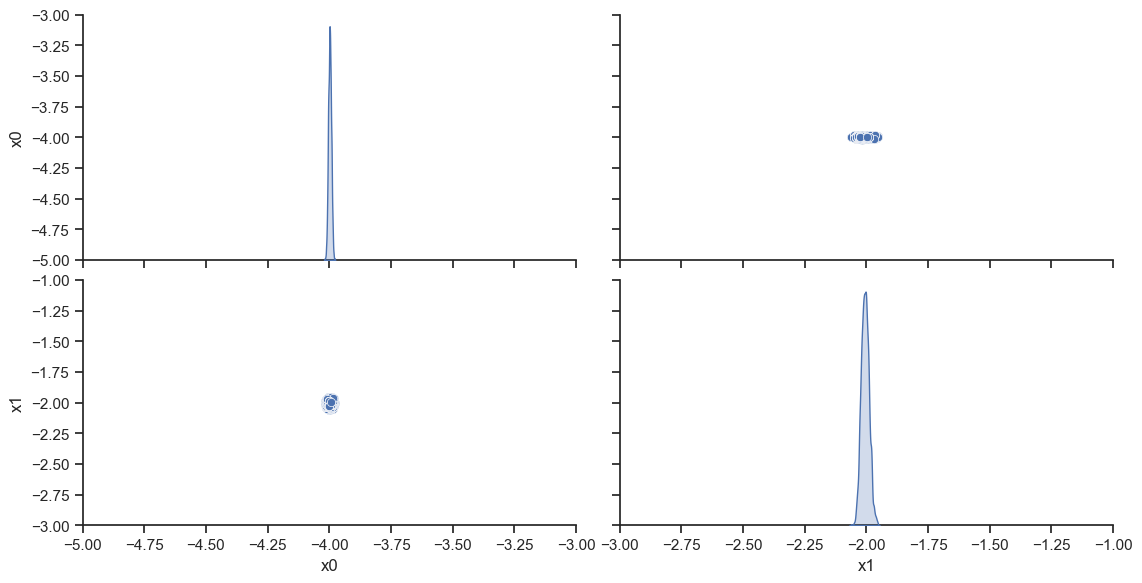

In [14]:
visualize.sampling_scatter(result, size=[13, 6]);